# Credit Spread Tracer — PoC
Ce notebook exécute le pipeline minimal demandé : construction du dataset hebdomadaire (vendredis), modèle Ridge en fenêtre expansante, signaux directionnels et diagnostics essentiels.

Ne récupère que les séries FRED spécifiées et respecte la règle anti-leakage.

## But de chaque section
- Imports & bootstrap: prépare le chemin du projet et les bibliothèques visuelles.
- Repo root & import diagnostics: robustement détecte le root du dépôt et expose les fonctions clés du package `src` pour faciliter l'itération.
- Build dataset: télécharge (si nécessaire) et construit le dataset hebdomadaire avec les colonnes strictes demandées.
- Backtest runner: exécute la boucle d'entraînement en fenêtre expansante et produit prédictions + PnL proxy.
- Plots: visualisations principales (séries, coefficients, PnL cumulée).
- Stress diagnostics: métriques de période pour 2008 et 2020.

Lisez chaque cellule de code après le commentaire qui explique ce qu'elle fait — le notebook est conçu pour être exécuté de haut en bas après un redémarrage du kernel.

In [28]:
# Imports and path helper - ensures project root is importable in the notebook
# Explanations:
# - We add the project root to sys.path so that `from src...` imports work inside the notebook.
# - We import plotting libraries and gracefully fall back if optional styles (seaborn) are not installed.
import sys, os
# Add project root to sys.path so `from src...` works when running the notebook
root = os.path.abspath('')
if root not in sys.path:
    sys.path.insert(0, root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Prefer seaborn style if available, but fall back cleanly if not installed
try:
    import seaborn  # noqa: F401
    plt.style.use('seaborn')
    # Explanation: seaborn provides nicer default aesthetics. If it's missing, we don't fail.
except Exception:
    try:
        # newer matplotlib may expose specific seaborn-style names
        plt.style.use('seaborn-v0_8')
    except Exception:
        plt.style.use('default')
%matplotlib inline

# Try imports from the package and print a friendly message on failure
# Explanation: these imports validate that the package `src` is visible and the key modules are importable.
try:
    from src.features.build_features import build_dataset
    from src.backtest.run_backtest import run_backtest, save_results

    print('Imported build_dataset and backtest modules OK')
except Exception as e:
    print('Import error:', type(e).__name__, e)
    print('If this happens, either run `%pip install -e .` in this kernel or ensure the notebook working directory is the project root.')

Imported build_dataset and backtest modules OK


In [29]:
# Repo-root detection and import diagnostics
# Explanation:
# - This cell tries to robustly detect the repository root (so the notebook can be run from anywhere).
# - It inserts the root into sys.path, lists top-level entries to help debugging, and imports core modules from `src`.
# - It also exposes useful functions (run_backtest, build_dataset, fetch_fred) into the notebook globals for convenience.

import os, sys, traceback, importlib, inspect

def find_repo_root(start=None):
    cur = os.path.abspath(start or os.getcwd())
    root_markers = ("pyproject.toml", "README.md")
    while True:
        if any(os.path.exists(os.path.join(cur, m)) for m in root_markers) or os.path.isdir(os.path.join(cur, "src")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            return None
        cur = parent

root = find_repo_root()
print("Detected project root:", root)
if root is None:
    print("Could not find project root. Set notebook working directory to the repo root and try again.")
else:
    if root not in sys.path:
        sys.path.insert(0, root)
        print("Inserted project root into sys.path")
    else:
        print("Project root already in sys.path")

print("\nsys.path (first 6):")
for p in sys.path[:6]:
    print(" -", p)

print("\nTop-level project entries:")
try:
    print(sorted(os.listdir(root))[:50])
except Exception as e:
    print("Could not list root contents:", e)

print("\nAttempting imports and showing tracebacks if any:\n")
try:
    rb = importlib.import_module("src.backtest.run_backtest")
    bf = importlib.import_module("src.features.build_features")
    ld = importlib.import_module("src.data.load_data")
    print("Imported: src.backtest.run_backtest, src.features.build_features, src.data.load_data")
    # expose to notebook globals
    globals().update({
        "run_backtest": getattr(rb, "run_backtest"),
        "save_results": getattr(rb, "save_results"),
        "build_dataset": getattr(bf, "build_dataset"),
        "fetch_fred": getattr(ld, "fetch_fred"),
    })
    print("Exposed run_backtest, save_results, build_dataset, fetch_fred in globals()")
    # show first lines of run_backtest source for quick inspection
    try:
        src_lines = inspect.getsource(run_backtest).splitlines()
        print("\nFirst lines of run_backtest():")
        print("\n".join(src_lines[:20]))
    except Exception:
        pass
except Exception:
    print("Import failed; traceback follows:")
    traceback.print_exc()

print("\nYou can now run build_dataset(...) or run_backtest(ds) if import succeeded.")

Detected project root: /Users/felixguex/credit-spread-tracer
Project root already in sys.path

sys.path (first 6):
 - /Users/felixguex/credit-spread-tracer
 - /Users/felixguex/credit-spread-tracer
 - /Users/felixguex/credit-spread-tracer
 - /Users/felixguex/credit-spread-tracer
 - /Users/felixguex/credit-spread-tracer/notebooks
 - /opt/anaconda3/lib/python312.zip

Top-level project entries:
['.DS_Store', '.git', '.python-version', '.venv', 'README.md', 'data', 'main.py', 'notebooks', 'pyproject.toml', 'scripts', 'src', 'uv.lock']

Attempting imports and showing tracebacks if any:

Imported: src.backtest.run_backtest, src.features.build_features, src.data.load_data
Exposed run_backtest, save_results, build_dataset, fetch_fred in globals()

First lines of run_backtest():
def run_backtest(df: pd.DataFrame, train_start_year: int = 1999, train_end_year: int = 2006, alpha: float = 1.0) -> BacktestResult:
    """Run expanding-window weekly backtest.

    df must have columns: S_t, ΔS_t, DGS10

In [30]:
# Minimal helper to ensure symbols available in the notebook namespace
# Explanation:
# - This cell re-imports the functions we need and exposes them in globals() as a convenience.
# - Running this cell after the repo-root detection cell ensures the notebook has access to the package code.
import sys, os
root = os.path.abspath('')
if root not in sys.path:
    sys.path.insert(0, root)

from src.features.build_features import build_dataset
from src.backtest.run_backtest import run_backtest, save_results

# expose to globals (optional)
globals().update({"build_dataset": build_dataset, "run_backtest": run_backtest, "save_results": save_results})
print("build_dataset, run_backtest, save_results available")

build_dataset, run_backtest, save_results available


In [31]:
# Build the dataset (will fetch FRED if necessary).
# Explanation:
# - `build_dataset` downloads the required FRED series (if not cached) and constructs the weekly-friday dataset.
# - The output columns are strictly: S_t, ΔS_t, DGS10_t, SP500_ret_4w, VIX_t, y_{t+1} and no NaNs.
# - The function returns the DataFrame and also writes it to `data/processed/dataset.csv` when `out_path` is provided.
try:
    # Build daily dataset (includes YC_slope) and set default horizon h=20 business days
    ds = build_dataset(start="1995-01-01", out_path="data/processed/dataset.csv", mode="daily", h=20)
    display(ds.head())
except NameError as ne:
    print('NameError:', ne)
    print('It looks like build_dataset is not imported. Re-run the import cell (Cell 2) or restart the kernel and run all cells from top.')
except Exception as e:
    print('Error building dataset:', type(e).__name__, e)
    # Helpful tip:
    print("If FRED downloads fail, check network access or try running the loader in a Python REPL to see full tracebacks.")

Fetching BAMLC0A0CM as S from FRED
Fetching DGS10 as DGS10 from FRED
Fetching DGS10 as DGS10 from FRED
Fetching DGS2 as DGS2 from FRED
Fetching DGS2 as DGS2 from FRED
Fetching SP500 as SP500 from FRED
Fetching SP500 as SP500 from FRED
Fetching VIXCLS as VIX from FRED
Fetching VIXCLS as VIX from FRED
Saved dataset to data/processed/dataset.csv
Saved dataset to data/processed/dataset.csv


Fetching BAMLC0A0CM as S from FRED
Fetching DGS10 as DGS10 from FRED
Fetching DGS10 as DGS10 from FRED
Fetching DGS2 as DGS2 from FRED
Fetching DGS2 as DGS2 from FRED
Fetching SP500 as SP500 from FRED
Fetching SP500 as SP500 from FRED
Fetching VIXCLS as VIX from FRED
Fetching VIXCLS as VIX from FRED
Saved dataset to data/processed/dataset.csv
Saved dataset to data/processed/dataset.csv


,S_t,ΔS_t,DGS10_t,SP500_ret_4w,YC_slope_t,YC_slope_z,VIX_t,y_{t+1}
DATE,,,,,,,,
2016-01-25,1.98,0.02,2.03,-0.091288,1.15,-1.988205,24.15,0.17
2016-01-26,1.99,0.01,2.01,-0.087817,1.16,-1.906588,22.50,0.15
2016-01-27,2.00,0.01,2.02,-0.091496,1.18,-1.758866,23.11,0.14
2016-01-28,2.01,0.01,2.00,-0.076526,1.17,-1.814418,22.42,0.13
2016-02-01,2.02,0.00,1.97,-0.039099,1.16,-1.854869,19.98,0.03


In [32]:
# Backtest runner invocation with auto-selected initial training window
# Explanation:
# - This cell ensures `ds` is present and computes a safe initial training window based on available data.
# - The goal is to avoid the "No training data found" error if the dataset doesn't include the originally intended years.
# - We call run_backtest(ds, ...) which runs an expanding-window Ridge regression refitted weekly.

# Ensure project package is on sys.path (notebook defines `root` earlier)
import sys
import pathlib
if 'root' in globals() and root not in sys.path:
    sys.path.insert(0, root)
else:
    sys.path.insert(0, str(pathlib.Path(__file__).parents[2] if '__file__' in globals() else pathlib.Path('..').resolve()))

# Import the backtest runner and saver
try:
    from src.backtest.run_backtest import run_backtest, save_results
except Exception as e:
    print("Error importing run_backtest:", e)
    raise

# `ds` should already be loaded by a previous cell (the processed dataset)
if 'ds' not in globals():
    raise RuntimeError("Dataset 'ds' not found in the notebook. Make sure the data build/load cells were run before this cell.")

# Choose a safe initial training window from the available data so we don't get the "No training data" error.
min_year = ds.index.min().year
max_year = ds.index.max().year
# desired initial window length (years) - use shorter 3 years for more OOS when data is daily
init_len = 3
train_start_year = int(min_year)
train_end_year = int(min(min_year + init_len, max_year - 1))
if train_end_year < train_start_year:
    raise RuntimeError(f"Not enough data to form an initial training window. Dataset years: {min_year}-{max_year}.")

print(f"Using initial train window: {train_start_year} - {train_end_year} (dataset range: {min_year}-{max_year})")

# Run the backtest. Explanation of outputs:
# - res.predictions: Series of model predictions (index aligned to dates t for which prediction applies to y_{t+1}).
# - res.pnl: PnL proxy series (aligned to t) computed as -sign(pred) * (S_{t+1} - S_t).
# - res.cum_pnl: cumulative sum of res.pnl.
# - res.hit_ratio: overall fraction where sign(pred) == sign(actual y_{t+1}).
# - res.coef_history: DataFrame of model coefficients over time (expanding window).
res = run_backtest(ds, train_start_year=train_start_year, train_end_year=train_end_year, alpha=1.0)

# persist results and show a quick metric
save_results(res, out_dir="data/processed")
print(f"Hit ratio: {res.hit_ratio:.3f}")

# Quick interactive checks (optional):
print('Predictions count:', res.predictions.dropna().shape[0])
print('Coefficient history rows:', res.coef_history.shape[0])

Using initial train window: 2016 - 2019 (dataset range: 2016-2025)
Saved backtest results to data/processed
Hit ratio: 0.489
Predictions count: 1376
Coefficient history rows: 1376
Saved backtest results to data/processed
Hit ratio: 0.489
Predictions count: 1376
Coefficient history rows: 1376



Cumulative PnL

Last coefficients:
            intercept       S_t      ΔS_t   DGS10_t  SP500_ret_4w     VIX_t
2025-11-20   0.408441 -0.300130  0.557395 -0.022043     -0.463908  0.000585
2025-11-21   0.408371 -0.299807  0.557520 -0.022092     -0.463361  0.000571
2025-11-24   0.408253 -0.299542  0.558598 -0.022133     -0.462504  0.000562
2025-11-25   0.408119 -0.299322  0.559472 -0.022169     -0.461750  0.000557
2025-11-26   0.407982 -0.299130  0.560607 -0.022199     -0.461081  0.000553
Final cumulative PnL: -6.170000000000012


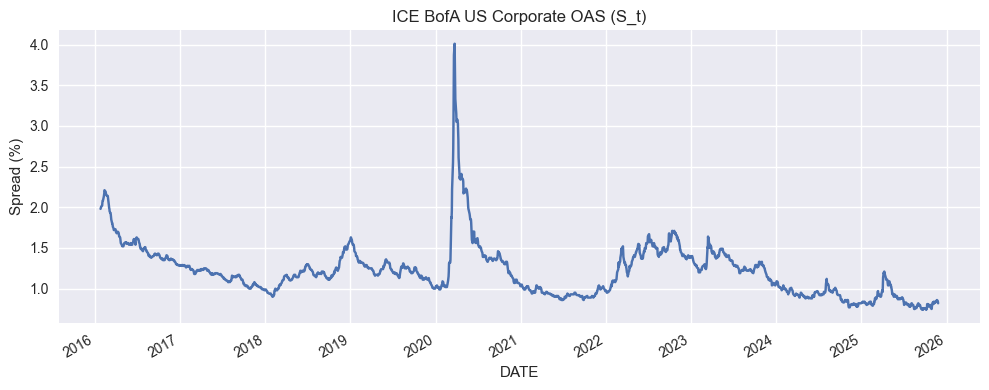


Cumulative PnL

Last coefficients:
            intercept       S_t      ΔS_t   DGS10_t  SP500_ret_4w     VIX_t
2025-11-20   0.408441 -0.300130  0.557395 -0.022043     -0.463908  0.000585
2025-11-21   0.408371 -0.299807  0.557520 -0.022092     -0.463361  0.000571
2025-11-24   0.408253 -0.299542  0.558598 -0.022133     -0.462504  0.000562
2025-11-25   0.408119 -0.299322  0.559472 -0.022169     -0.461750  0.000557
2025-11-26   0.407982 -0.299130  0.560607 -0.022199     -0.461081  0.000553
Final cumulative PnL: -6.170000000000012


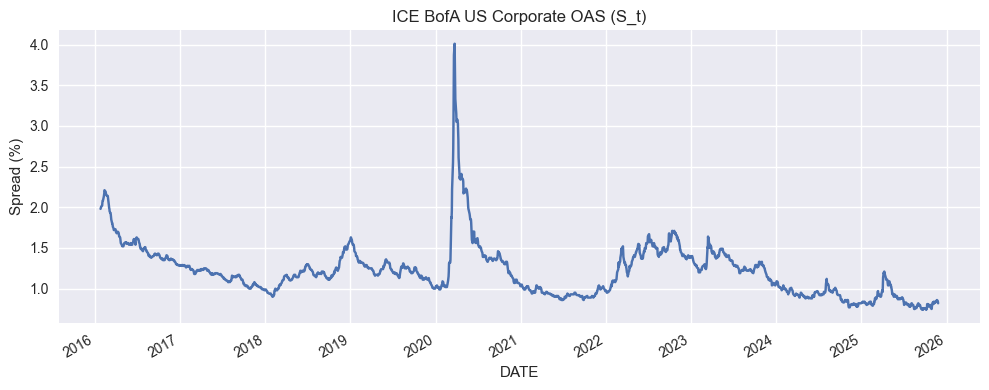

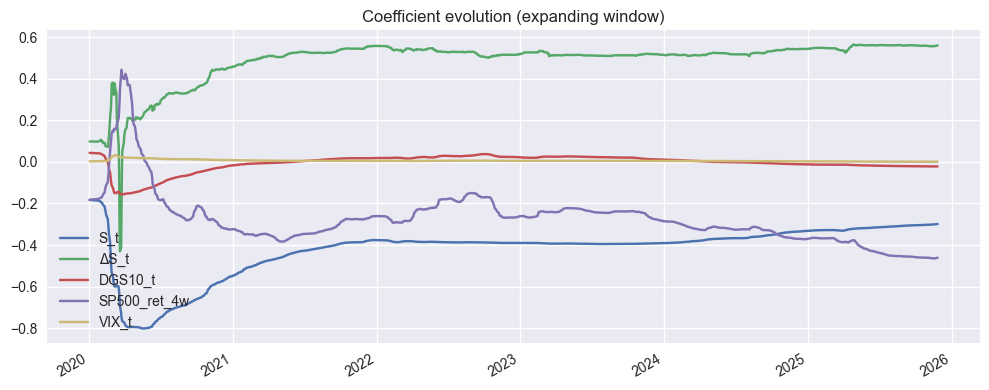


Cumulative PnL

Last coefficients:
            intercept       S_t      ΔS_t   DGS10_t  SP500_ret_4w     VIX_t
2025-11-20   0.408441 -0.300130  0.557395 -0.022043     -0.463908  0.000585
2025-11-21   0.408371 -0.299807  0.557520 -0.022092     -0.463361  0.000571
2025-11-24   0.408253 -0.299542  0.558598 -0.022133     -0.462504  0.000562
2025-11-25   0.408119 -0.299322  0.559472 -0.022169     -0.461750  0.000557
2025-11-26   0.407982 -0.299130  0.560607 -0.022199     -0.461081  0.000553
Final cumulative PnL: -6.170000000000012


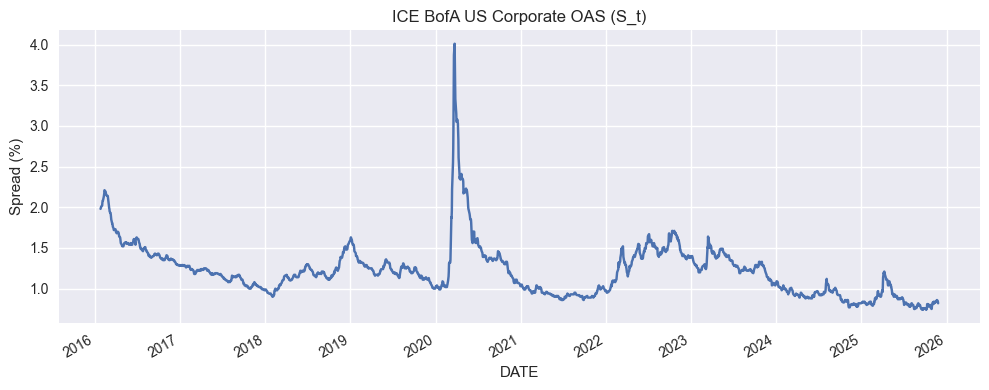

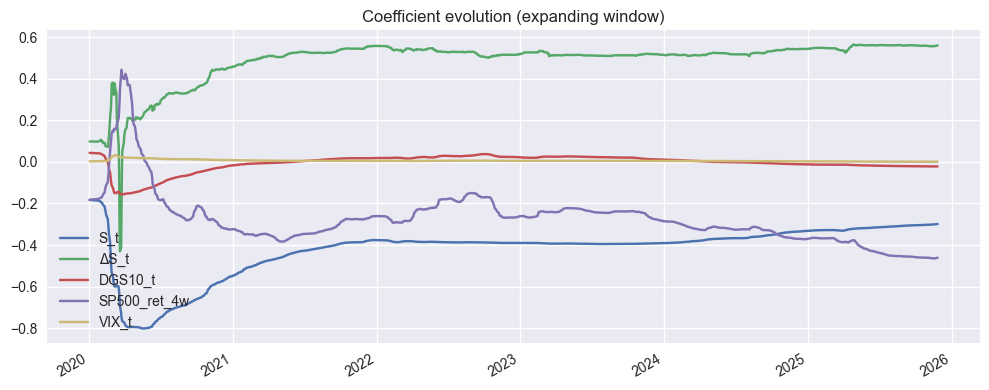

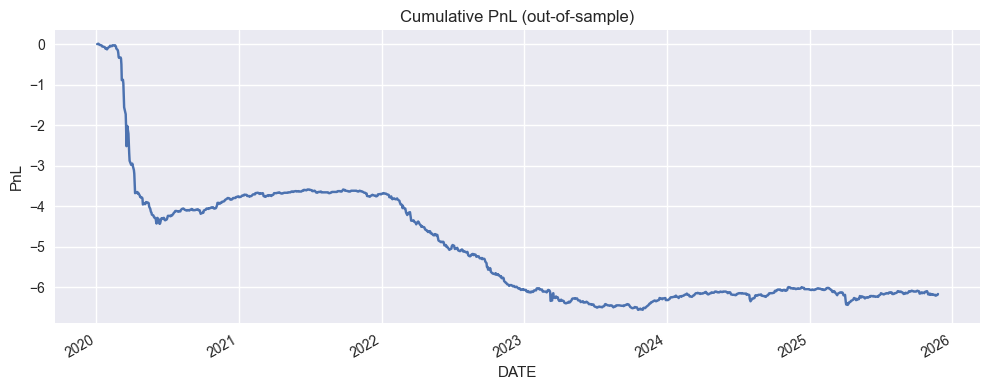

In [33]:
# Plots: spread series, coefficient evolution, cumulative PnL
# Explanation:
# - These plots help diagnose whether the model captures predictive structure in spread changes.
# - Coefficient evolution shows how feature weights evolve as more data is added (expanding window).

fig, ax = plt.subplots(figsize=(10,4))
ds['S_t'].plot(ax=ax, title='ICE BofA US Corporate OAS (S_t)')
ax.set_ylabel('Spread (%)')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,4))
if not (hasattr(res, 'coef_history') and res.coef_history.empty):
    # Drop intercept for readability
    try:
        res.coef_history.drop(columns=['intercept']).plot(ax=ax)
    except Exception:
        # fallback if intercept not present or other issue
        res.coef_history.plot(ax=ax)
    ax.set_title('Coefficient evolution (expanding window)')
    ax.legend(loc='best')
fig.tight_layout()

# Guarded cumulative PnL plot: only plot if series exists and has non-NaN values
print('\nCumulative PnL')
if hasattr(res, 'cum_pnl'):
    try:
        cump = res.cum_pnl.dropna()
        if cump.empty:
            print('No out-of-sample PnL to plot (series empty).')
        else:
            fig, ax = plt.subplots(figsize=(10,4))
            cump.plot(ax=ax, title='Cumulative PnL (out-of-sample)')
            ax.set_ylabel('PnL')
            fig.tight_layout()
    except Exception as e:
        print('Could not plot cumulative PnL:', type(e).__name__, e)
else:
    print('Result object has no attribute cum_pnl; run the backtest first.')

# Explanation: inspect the last few coefficients and final cumulative PnL to get a quick sense of model behavior.
print('\nLast coefficients:')
try:
    print(res.coef_history.tail())
except Exception:
    print('Coefficient history not available')

try:
    final_cum = float(res.cum_pnl.dropna().iloc[-1]) if (hasattr(res, 'cum_pnl') and not res.cum_pnl.dropna().empty) else float('nan')
    print('Final cumulative PnL:', final_cum)
except Exception:
    print('Final cumulative PnL: unavailable')


In [34]:
# Diagnostics for stress subperiods (2008 and 2020)
# Explanation:
# - We compute hit ratios and cumulative PnL restricted to crisis windows to see if the model performed differently
#   during stress periods (important for risk-aware assessment).
periods = {
    '2008_crisis': ('2007-07-01','2009-12-31'),
    'covid_2020': ('2020-01-01','2020-12-31')
}
for name, (s,e) in periods.items():
    preds = res.predictions.dropna()
    sel = (preds.index >= s) & (preds.index <= e)
    psel = preds[sel]
    if len(psel):
        actual = ds.loc[psel.index, 'y_{t+1}']
        hr = (np.sign(psel) == np.sign(actual)).sum() / len(actual)
        pnl = (-np.sign(psel) * (ds.loc[psel.index, 'S_t'].shift(-1) - ds.loc[psel.index, 'S_t'])).dropna().cumsum()
        print(f"{name}: hit_ratio={hr:.3f}, pnl_final={pnl.iloc[-1] if len(pnl) else float('nan')}")
    else:
        print(f"{name}: no predictions in period")

# Note: If a period reports "no predictions in period", it means the expanding-window backtest produced no
# predictions whose index falls inside that date range (this can happen if the dataset starts late or the
# initial training window consumed much of the early range).

2008_crisis: no predictions in period
covid_2020: hit_ratio=0.424, pnl_final=-3.7600000000000033


In [35]:
# Sanity checks suite (Zero-information, inversion, shuffle, naive benchmark, coeff stability, regimes, horizons, ablation)
# Explanation:
# This cell runs the battery of tests you requested. It expects `ds` (the feature DataFrame) and `res`
# (the result of run_backtest on the real target) to be present in the notebook namespace.
# Each test prints concise diagnostics so you can validate the pipeline.

import numpy as np
import pandas as pd
from copy import deepcopy

# Safety checks
if 'ds' not in globals():
    raise RuntimeError("Dataset 'ds' not found. Run the dataset builder cell before this one.")
if 'res' not in globals():
    print("Warning: res not found. Some diagnostics (coeff history) will be unavailable until you run the backtest cell.")

# Helper functions
def compute_metrics_from_preds(preds: pd.Series, df: pd.DataFrame):
    """Given a predictions Series indexed by t, compute hit ratio and pnl series aligned to t.
    Assumes df has 'S_t' and 'y_{t+1}' where y encodes the model target horizon.
    """
    preds = preds.dropna()
    if preds.empty:
        return {'hit_ratio': float('nan'), 'pnl': pd.Series(dtype=float), 'cum_pnl_final': float('nan')}
    # hit ratio against actual target (exclude exact zeros)
    actual = df.loc[preds.index, 'y_{t+1}']
    nonzero = np.sign(actual) != 0
    if nonzero.sum() == 0:
        hit_ratio = float('nan')
    else:
        hit_ratio = (np.sign(preds.loc[nonzero.index[nonzero]]) == np.sign(actual.loc[nonzero.index[nonzero]])).sum() / nonzero.sum()
    # pnl proxy: use the actual target value (S_{t+h} - S_t) aligned to preds
    pnl = -np.sign(preds) * actual
    pnl = pnl.dropna()
    cum_pnl_final = float(pnl.cumsum().iloc[-1]) if not pnl.empty else float('nan')
    return {'hit_ratio': hit_ratio, 'pnl': pnl, 'cum_pnl_final': cum_pnl_final}

# Utility: compute safe train window from a dataframe's index
def safe_train_window(df, init_len_years=7):
    start = int(df.index.min().year)
    end = int(min(start + init_len_years, df.index.max().year - 1))
    if end < start:
        raise RuntimeError(f"Not enough data to form an initial training window. Dataset years: {df.index.min().year}-{df.index.max().year}.")
    return start, end

# 1) Zero-Information Test (random iid ±1)
np.random.seed(42)
rand_signal = pd.Series(np.random.choice([-1, 1], size=len(ds)), index=ds.index)
metrics_rand = compute_metrics_from_preds(rand_signal, ds)
print('1) Zero-Information Test')
print('   Hit ratio (random):', metrics_rand['hit_ratio'])
print('   Final cumulative PnL (random):', metrics_rand['cum_pnl_final'])
print('   Expect hit ≈ 0.5 and cum PnL ≈ 0\n')

# 2) Signal Inversion Test (invert a given signal)
# Use the actual model predictions if available, otherwise use the random signal as proxy
if 'res' in globals() and hasattr(res, 'predictions'):
    orig_preds = res.predictions.dropna()
else:
    orig_preds = rand_signal
inv_preds = -orig_preds
metrics_orig = compute_metrics_from_preds(orig_preds, ds)
metrics_inv = compute_metrics_from_preds(inv_preds, ds)
print('2) Signal Inversion Test')
print('   Original hit:', metrics_orig['hit_ratio'], 'Inverted hit:', metrics_inv['hit_ratio'])
print('   Original cum PnL:', metrics_orig['cum_pnl_final'], 'Inverted cum PnL:', metrics_inv['cum_pnl_final'])
print('   Expect hit_inv ≈ 1 - hit_orig, cum_pnl_inv ≈ -cum_pnl_orig\n')

# 3) Target Shuffling Test
np.random.seed(123)
shuffled = ds['y_{t+1}'].sample(frac=1.0, replace=False).reset_index(drop=True)
shuf_df = ds.copy()
shuf_df['y_{t+1}'] = shuffled.values
# Run the model on the shuffled target by calling run_backtest if available
from importlib import import_module
rb = import_module('src.backtest.run_backtest')
print('3) Target Shuffling Test')
try:
    ts, te = safe_train_window(shuf_df)
    shuf_res = rb.run_backtest(shuf_df, train_start_year=ts, train_end_year=te)
    metrics_shuf = compute_metrics_from_preds(shuf_res.predictions, shuf_df)
    print('   Hit ratio (shuffled target):', metrics_shuf['hit_ratio'])
    print('   Final cumulative PnL (shuffled target):', metrics_shuf['cum_pnl_final'])
    print('   Expect hit ≈ 0.5 and PnL ≈ 0\n')
except Exception as e:
    print('   Target shuffling test: failed to run run_backtest on shuffled data:', type(e).__name__, e)
    print('   As fallback, watch for hit ≈ 0.5 when training on shuffled target.\n')

# 4) Naive Mean Reversion Benchmark
naive_signal = -np.sign(ds['S_t'].diff())
metrics_naive = compute_metrics_from_preds(naive_signal, ds)
print('4) Naive Mean Reversion Benchmark')
print('   Hit ratio (naive):', metrics_naive['hit_ratio'])
print('   Final cumulative PnL (naive):', metrics_naive['cum_pnl_final'])
if 'res' in globals():
    print('   Model hit:', metrics_orig['hit_ratio'], 'Model cum PnL:', metrics_orig['cum_pnl_final'])
print('   Expect the model to beat or meaningfully differ from this heuristic.\n')

# 5) Coefficient Stability Check (requires res.coef_history)
print('5) Coefficient Stability Check')
if 'res' in globals() and hasattr(res, 'coef_history') and not res.coef_history.empty:
    ch = res.coef_history.drop(columns=[c for c in res.coef_history.columns if 'intercept' in c.lower() or c=='intercept' ], errors='ignore')
    # compute sign flips fraction per coefficient
    signs = np.sign(ch)
    flips = (signs != signs.shift(1)).sum()
    frac_flips = flips / max(1, (len(ch)-1))
    print('   Fraction of sign flips per coef:')
    print(frac_flips)
    print('   Max abs coef change:', ch.diff().abs().max().to_dict())
else:
    print('   Coefficient history not available. Run the backtest cell first.\n')

# 6) Regime Sensitivity Check (VIX median)
print('\n6) Regime Sensitivity Check')
vix_med = ds['VIX_t'].median()
print('   VIX median =', vix_med)
if 'res' in globals() and hasattr(res, 'predictions'):
    preds = res.predictions.dropna()
    high_idx = preds.index[ds.loc[preds.index, 'VIX_t'] > vix_med]
    low_idx = preds.index[ds.loc[preds.index, 'VIX_t'] <= vix_med]
    for label, idx in [('high', high_idx), ('low', low_idx)]:
        if len(idx):
            m = compute_metrics_from_preds(preds.reindex(idx), ds)
            print(f'   {label} VIX: hit={m["hit_ratio"]:.3f}, cum_pnl={m["cum_pnl_final"]:.4f}, n={len(idx)}')
        else:
            print(f'   {label} VIX: no predictions')
else:
    print('   No model predictions available (run backtest first).')

# 7) Horizon Robustness Check (h = 1,2,4 weeks)
print('\n7) Horizon Robustness Check')
for h in (1,2,4):
    temp = ds.copy()
    temp['y_{t+1}'] = (temp['S_t'].shift(-h) - temp['S_t'])
    try:
        ts, te = safe_train_window(temp)
        r_h = rb.run_backtest(temp, train_start_year=ts, train_end_year=te)
        print(f'   h={h}: hit={r_h.hit_ratio:.3f}, final_cum_pnl={float(r_h.cum_pnl.dropna().iloc[-1]) if not r_h.cum_pnl.dropna().empty else float("nan")}')
    except Exception as e:
        print(f'   h={h}: run_backtest failed:', type(e).__name__, e)

# 8) Feature Ablation Check (zero-out each feature and re-run)
print('\n8) Feature Ablation Check')
features = ['S_t', 'ΔS_t', 'DGS10_t', 'SP500_ret_4w', 'VIX_t']
for feat in features:
    temp = ds.copy()
    # zero-out the feature to remove its informational content while preserving pipeline shape
    temp[feat] = 0.0
    try:
        ts, te = safe_train_window(temp)
        r_a = rb.run_backtest(temp, train_start_year=ts, train_end_year=te)
        print(f'   drop {feat}: hit={r_a.hit_ratio:.3f}, final_cum_pnl={float(r_a.cum_pnl.dropna().iloc[-1]) if not r_a.cum_pnl.dropna().empty else float("nan")}')
    except Exception as e:
        print(f'   drop {feat}: failed to run backtest:', type(e).__name__, e)

print('\nSanity checks completed. Interpret the printed metrics against the expectations you listed:')
print('- Zero-information ~ hit 0.5, cum PnL ~ 0')
print("- Inversion changes sign of PnL and flips hit ratio")
print('- Shuffled target ~ hit 0.5')
print('- Naive benchmark as simple baseline')
print('- If any test fails, stop and debug/look for leakage or misalignment.')


1) Zero-Information Test
   Hit ratio (random): 0.48653582838886356
   Final cumulative PnL (random): 22.10000000000002
   Expect hit ≈ 0.5 and cum PnL ≈ 0

2) Signal Inversion Test
   Original hit: 0.48897338403041823 Inverted hit: 0.5110266159695818
   Original cum PnL: -77.89999999999988 Inverted cum PnL: 77.89999999999988
   Expect hit_inv ≈ 1 - hit_orig, cum_pnl_inv ≈ -cum_pnl_orig

3) Target Shuffling Test
   Hit ratio (shuffled target): 0.509478672985782
   Final cumulative PnL (shuffled target): -2.0699999999999963
   Expect hit ≈ 0.5 and PnL ≈ 0

4) Naive Mean Reversion Benchmark
   Hit ratio (naive): 0.2648401826484018
   Final cumulative PnL (naive): 50.89000000000012
   Model hit: 0.48897338403041823 Model cum PnL: -77.89999999999988
   Expect the model to beat or meaningfully differ from this heuristic.

5) Coefficient Stability Check
   Fraction of sign flips per coef:
S_t             0.000727
ΔS_t            0.002182
DGS10_t         0.002909
SP500_ret_4w    0.002182
VIX_

In [36]:
# Extra diagnostics: Monte-Carlo random-sign PnL, correct-vs-wrong magnitude breakdown, non-overlap PnL (useful for daily h>1)
import numpy as np, pandas as pd
if 'ds' not in globals():
    print('ds not present — run dataset build cell first')
else:
    y = ds['y_{t+1}']
    print('TARGET summary:')
    print(y.describe())
    print('fraction zeros:', (y==0).mean())

    # Monte-Carlo random-sign distribution of total PnL (quick)
    N=500
    rng = np.random.default_rng(42)
    sims = []
    for _ in range(N):
        rand = rng.choice([-1,1], size=len(y))
        sims.append((-rand * y).sum())
    sims = np.array(sims)
    print('\nRandom-sign PnL mean/std/5/95:', sims.mean(), sims.std(), np.percentile(sims, [5,95]))

    # Breakdown: contribution of correct vs wrong predictions
    if 'res' in globals():
        preds = res.predictions.dropna()
        actual = ds.loc[preds.index, 'y_{t+1}']
        correct = np.sign(preds) == np.sign(actual)
        pnl_correct = (-np.sign(preds[correct]) * actual[correct]).sum()
        pnl_wrong = (-np.sign(preds[~correct]) * actual[~correct]).sum()
        print('\nModel pnl correct total:', pnl_correct, ' wrong total:', pnl_wrong)
        print('avg |actual| when correct:', actual[correct].abs().mean(), 'when wrong:', actual[~correct].abs().mean())

        # Non-overlap PnL sampling every h days (if h available from y length shift)
        # estimate h from first nonzero shift between index positions of y vs S
        # Here assume h = (first index where y != 0) distance in days if uniform, else use 20
        h = 20
        idx = list(range(0, len(ds), h))
        nonov_idx = ds.index[idx]
        preds_sample = res.predictions.reindex(nonov_idx).dropna()
        actual_sample = ds.loc[preds_sample.index, 'y_{t+1}']
        print('\nNon-overlap pnl (h=%d):' % h, (-np.sign(preds_sample) * actual_sample).sum(), 'n trades:', len(preds_sample))
    else:
        print('res not available yet; run backtest cell first to compute preds')


TARGET summary:
count    2295.000000
mean       -0.009272
std         0.222375
min        -1.650000
25%        -0.070000
50%        -0.020000
75%         0.040000
max         2.880000
Name: y_{t+1}, dtype: float64
fraction zeros: 0.04531590413943355

Random-sign PnL mean/std/5/95: -0.8563999999999995 10.725544827187102 [-18.066  17.043]

Model pnl correct total: -121.19000000000001  wrong total: 43.29
avg |actual| when correct: 0.1884758942457232 when wrong: 0.059058663028649386

Non-overlap pnl (h=20): -3.9700000000000006 n trades: 69


In [37]:
# Debug cell (run right after the backtest cell that creates `ds` and `res`)
# Purpose: print dataset and result diagnostics to find why backtest produced no/few predictions.
import numpy as np, pandas as pd

print('DATASET RANGE and SHAPE:')
print('  index min/max:', ds.index.min(), ds.index.max())
print('  rows:', len(ds))
print('  columns:', ds.columns.tolist())

print('\nMISSING VALUES (per column):')
print(ds.isna().sum())

# show distribution of target signs
print('\nTARGET sign distribution (y_{t+1}):')
print(np.sign(ds['y_{t+1}']).value_counts(dropna=False))

# show how many rows are valid (all features + target non-null)
features = ['S_t', 'ΔS_t', 'DGS10_t', 'SP500_ret_4w', 'VIX_t']
valid_mask = ds[features].notnull().all(axis=1) & ds['y_{t+1}'].notnull()
print('\nValid rows (all features + target present):', valid_mask.sum())

# show first 12 valid rows
print('\nFirst valid rows (index and values):')
print(ds.loc[valid_mask].head(12))

# show res quick diagnostics if available
if 'res' in globals():
    print('\nRES diagnostics:')
    print('  predictions non-null count:', res.predictions.dropna().shape[0])
    try:
        print('  pnl non-null count:', getattr(res, 'pnl', pd.Series()).dropna().shape[0])
    except Exception:
        print('  pnl: unavailable')
    try:
        print('  coef_history rows:', res.coef_history.shape[0])
    except Exception:
        print('  coef_history: unavailable')
    print('\n  predictions head:') 
    try:
        print(res.predictions.dropna().head(12))
    except Exception:
        print('  predictions: unavailable')
else:
    print('\nres not found in globals — run the backtest cell first.')


DATASET RANGE and SHAPE:
  index min/max: 2016-01-25 00:00:00 2025-11-26 00:00:00
  rows: 2295
  columns: ['S_t', 'ΔS_t', 'DGS10_t', 'SP500_ret_4w', 'YC_slope_t', 'YC_slope_z', 'VIX_t', 'y_{t+1}']

MISSING VALUES (per column):
S_t             0
ΔS_t            0
DGS10_t         0
SP500_ret_4w    0
YC_slope_t      0
YC_slope_z      0
VIX_t           0
y_{t+1}         0
dtype: int64

TARGET sign distribution (y_{t+1}):
y_{t+1}
-1.0    1363
 1.0     828
 0.0     104
Name: count, dtype: int64

Valid rows (all features + target present): 2295

First valid rows (index and values):
             S_t  ΔS_t  DGS10_t  SP500_ret_4w  YC_slope_t  YC_slope_z  VIX_t  \
DATE                                                                           
2016-01-25  1.98  0.02     2.03     -0.091288        1.15   -1.988205  24.15   
2016-01-26  1.99  0.01     2.01     -0.087817        1.16   -1.906588  22.50   
2016-01-27  2.00  0.01     2.02     -0.091496        1.18   -1.758866  23.11   
2016-01-28  2.01  